# EDA and Preprocessing Notebook
We will read the data from the __CSV__ file into a Pandas Dataframe and perform some EDA to understand the file contents

## Business goal
We are analyzing the data of __Amazon Logistics (AMZL)__ which is in charge of last mile delivery to customers. We wish to manage the operational capacity of the delivery stations using upstream data from the connections and capacity between Amazon fulfillment and sortation centres, and the downsteam data about delivery capacity and customer demands. The data is in the form of time series, with the goal being to predict inflow and outflow from delivery stations based on past and current data.

In [1]:
import pandas as pd
from sklearn import preprocessing
import category_encoders as ce
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline

In [2]:
df = pd.read_csv("../../Data/Raw/train_data.csv")

In [3]:
df.head()

,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline
0,2021-06-30,C,"F6, F8, F14, F17",D33,14594,14568,782,896,615,767,35,2,4
1,2021-06-30,C,"F6, F8, F9, F14, F17, F18",D37,12736,13111,655,823,211,29,17,2,1
2,2021-06-30,C,"F1, F4, F6, F7, F13, F15, F16",D34,14562,15651,1028,1910,225,35,47,3,1
3,2021-06-30,C,"F2, F6, F7, F10, F12, F13, F14, F15, F19",D45,11165,11467,514,769,56,39,29,0,1
4,2021-06-30,C,"F6, F8, F13, F14, F17",D50,10006,10423,399,842,52,60,65,1,1


In [4]:
df.describe()

,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline
count,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000,11309.000000
mean,16107.803254,16050.335662,644.620656,653.369882,215.780175,231.747811,162.216642,181.492970,175.501547
std,7390.784150,7242.689184,604.513009,609.118523,475.355339,602.885062,303.522951,497.362834,485.388451
min,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,11298.000000,11337.000000,220.000000,225.000000,76.000000,51.000000,40.000000,0.000000,0.000000
50%,14644.000000,14617.000000,463.000000,475.000000,120.000000,87.000000,81.000000,2.000000,2.000000
75%,19113.000000,19120.000000,867.000000,876.000000,208.000000,183.000000,148.000000,115.000000,119.000000
max,50365.000000,50421.000000,4934.000000,5219.000000,17411.000000,18839.000000,5479.000000,8090.000000,8121.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11309 entries, 0 to 11308
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ofd_date      11309 non-null  object
 1   country_code  11309 non-null  object
 2   fc_codes      11309 non-null  object
 3   station_code  11309 non-null  object
 4   OFD           11309 non-null  int64 
 5   Slam          11309 non-null  int64 
 6   Earlies_Exp   11309 non-null  int64 
 7   Earlies_Rec   11309 non-null  int64 
 8   MNR_SNR_Exp   11309 non-null  int64 
 9   Rollover      11309 non-null  int64 
 10  Returns       11309 non-null  int64 
 11  R_Sideline    11309 non-null  int64 
 12  Sideline      11309 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


## Column Explanations
The values of the following columns are as follows:
*  __ofd_date__: Delivery date for customers (YYYY-mm-dd) (Feature) (Convert to datetime)
*  __country_code__: Contains single alphabet code (["A","B","C","D"]) (Feature) (Use one-hot encoding)
*  __fc_codes__: Contains list of fulfillment centres delivering to this station (Strings with F[1-56] separated by commas) (Feature) (Use one-hot encoding again)
*  __Station_code__: The code for this particular delivery stations (Feature) (string D[1-80]) (Use one-hot encoding)
*  __OFD__: Number of packages out for delivery today (Feature) (Integer) (Better not to normalize since min and max values can vary over different timeframes)
*  __Slam__: Number of packages reaching Delivery Centre from the Fulfillment Centres today (Feature) (Integer)
*  __Earlies_Rec__: Number of packages received earlier than planned date (Feature) (Integer)
*  __Rollover__: Number of packages which can't be delivered today and must be delivered tomorrow (Feature) (Integer)
*  __Returns__: Packages which could not be delivered to customers today and must be delivered tomorrow (Feature) (Integer)
*  __R_Sideline__: Packages sidelined yesterday which must be delivered today (Feature) (Integer)
*  __Sideline__: Number of packages for which customers were not available to receive, must be delivered tomorrow (Feature) (Integer)
*  __Earliest_Exp__: Packages expected to arrive earlier than planned date to station (Target) (Integer)
*  __MNR_SNR_Exp__: Packages expected not to arrive on planned date due to operational or other reasons (Target) (Integer)

MNR -> Manifests Not Received

Primary Key = OFD + Station code
Offset Exp = Earliest Exp - MNR_SNR_Exp

[OFD] = [Slam] + [Earlies_Exp] - [Earlies_Rec] - [MNR_SNR_Exp] + [Rollover] + [Returns] + [R_Sideline] - [Sideline] + [Other]

Hence, we should find these two target values, either separately or using an ensemble model, and then combine their results together and submit this value for further use. The predictions rely on whether packages will arrive earlier or later than the predicted delivery date. Based on these two values, we can plan approximately how many packages will be out for delivery on a given day and arrange operational capacity accordingly.

## Current model being used by AMZL

We calculate the ratios of the two targets over the Slam volume (Number of packages reaching the station on that day). We use an ensemble of different models which account for the day of week, weekly trends, and the last 3 day trends to account for seasonality and general trends. The weighted average of these models provides the expected values of both targets.

## Data preprocessing steps

1. Convert ofd_date to datetime format
2. Convert country_code to one-hot encoded columns
3. Convert fc_codes to list of strings using apply and then perform Multi Laber Binarizer
4. Convert station_code values to one-hot encoded columns
5. Delete the original columns used to derive new columns
6. Get the day of week and week of the year from the dates

After we perform Data preprocessing, we can attempt basic EDA

In [6]:
df['ofd_date'] = pd.to_datetime(df['ofd_date'], format = "%Y-%m-%d")

([<matplotlib.axis.YTick at 0x7fd110fd7f40>,
 [Text(0, 0, 'OFD'),
  Text(0, 1, 'Slam'),
  Text(0, 2, 'Earlies_Exp'),
  Text(0, 3, 'Earlies_Rec'),
  Text(0, 4, 'MNR_SNR_Exp'),
  Text(0, 5, 'Rollover'),
  Text(0, 6, 'Returns'),
  Text(0, 7, 'R_Sideline'),
  Text(0, 8, 'Sideline')])

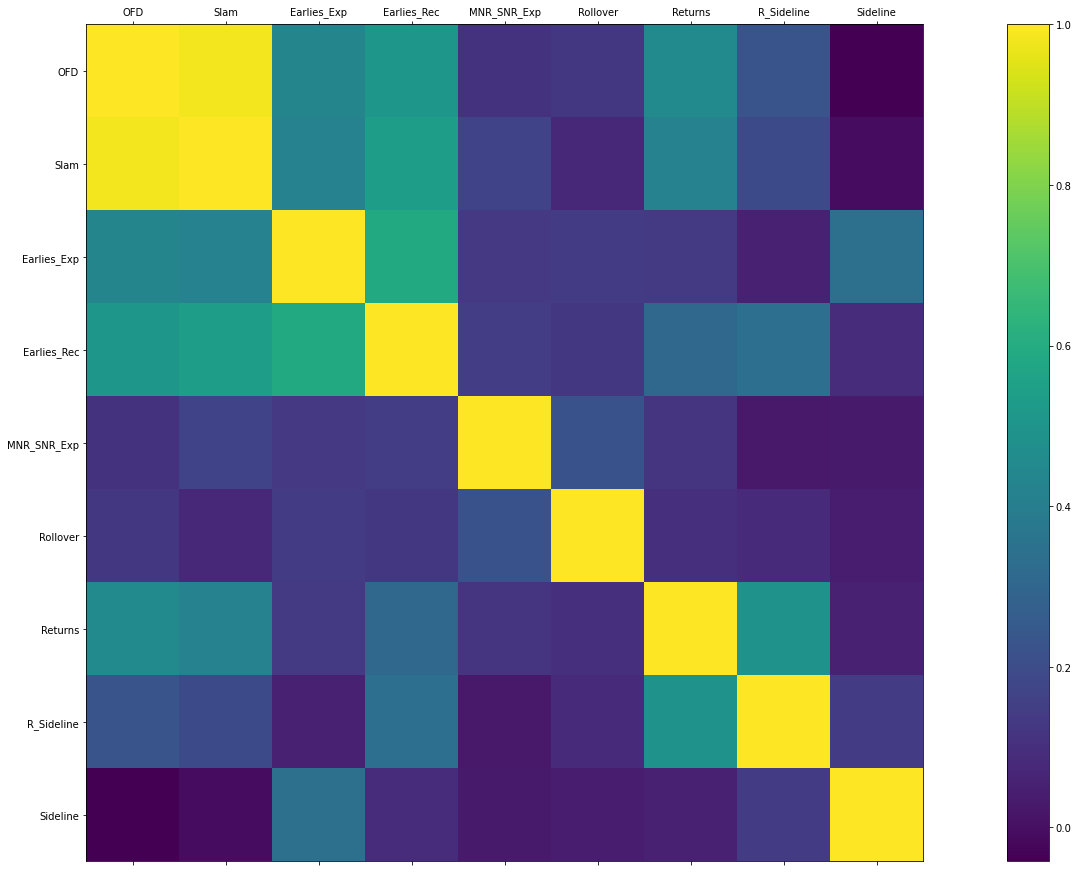

In [7]:
corr = df.corr(method = "pearson")
plt.matshow(corr)
cb = plt.colorbar()
plt.gcf().set_size_inches(30, 15)
plt.xticks(ticks=range(9), labels=corr.columns.values)
plt.yticks(ticks=range(9), labels=corr.columns.values)

In [70]:
df = pd.concat([df, pd.get_dummies(df.country_code, prefix = "Country")], axis=1)
df.drop(columns=["country_code"], inplace=True)

In [71]:
df["fc_codes"] = df["fc_codes"].apply(lambda x: x.replace(" ","").split(","))

In [72]:
mlb = preprocessing.MultiLabelBinarizer()

In [73]:
df = df.join(pd.DataFrame(mlb.fit_transform(df.fc_codes), columns = "Fulfil_" + mlb.classes_))
df.drop(columns=["fc_codes"], inplace=True)

In [74]:
df = pd.concat([df, pd.get_dummies(df.station_code, prefix = "Delivery")], axis=1)
df.drop(columns=["station_code"], inplace=True)

In [75]:
df["weekday"] = df["ofd_date"].dt.weekday

In [76]:
df["week_no"] = df["ofd_date"].dt.isocalendar().week

In [77]:
cols = df.columns[1:]
df[cols] = df[cols].apply(lambda x: pd.to_numeric(x, downcast='integer'), axis=0)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11309 entries, 0 to 11308
Columns: 151 entries, ofd_date to week_no
dtypes: Float32(1), datetime64[ns](1), float32(65), uint8(84)
memory usage: 3.9 MB


In [79]:
df = df.iloc[::-1]

In [80]:
df.to_excel("..\..\Data\Preprocessed\\train_data.xlsx", index=False)

In [ ]:
df = pd.read_excel("..\..\Data\Preprocessed\\train_data.xlsx")

In [ ]:
df.info()

In [ ]:
cols = df.columns[1:]
df[cols] = df[cols].apply(lambda x: pd.to_numeric(x, downcast='integer'), axis=0)

In [ ]:
df.info()

## Types of EDA to perform

Since all the data present here is time series data, the only variation should be due to change in time, hence the variables are univariate. We can perform the following analyses to check the data

### Statistical measures
* Mean
* Median
* Mode
* Variance

### Graphical measures
* Histograms
* Barplots
* Boxplots
* Density plots

We can also compare the different variables between each other using the cross correlation matrix and scatterplot matrix, and based on these correlation values and scatterplot values, we can decide which variables to modify and how to design the model

array([[<AxesSubplot:title={'center':'OFD'}>]], dtype=object)

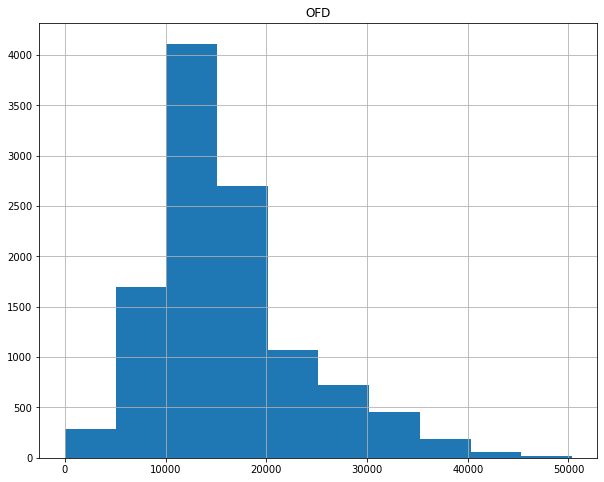

In [19]:
df.hist("OFD", figsize = (10,8))

<AxesSubplot:>

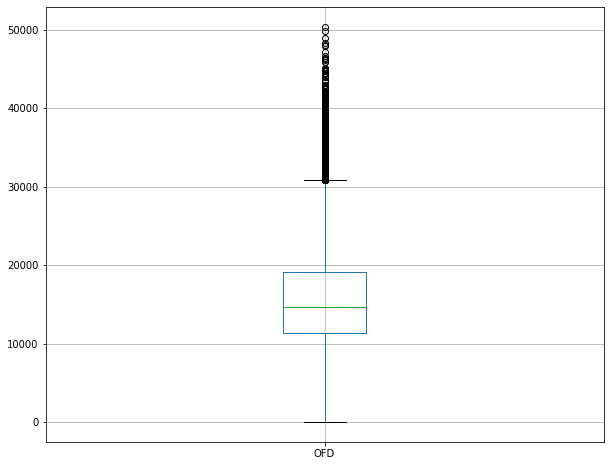

In [20]:
df.boxplot("OFD", figsize = (10,8))

array([[<AxesSubplot:title={'center':'Slam'}>]], dtype=object)

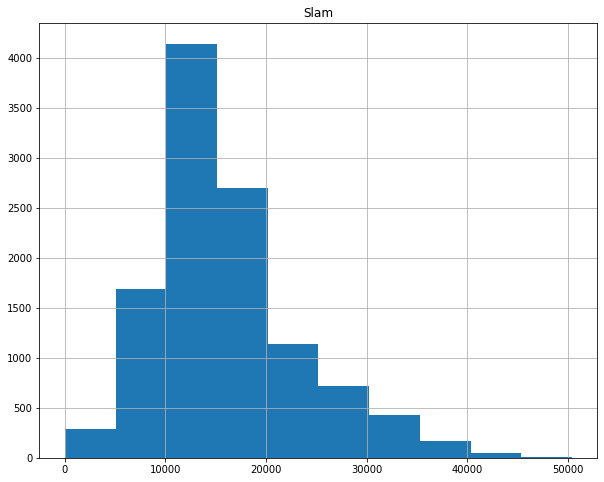

In [21]:
df.hist("Slam", figsize = (10,8))

<AxesSubplot:>

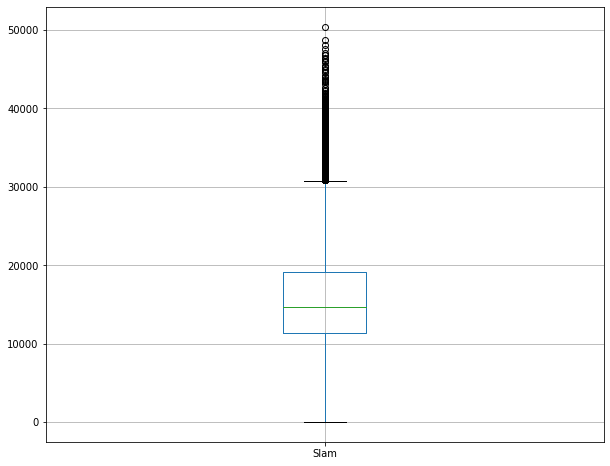

In [22]:
df.boxplot("Slam", figsize = (10,8))

array([[<AxesSubplot:title={'center':'Earlies_Exp'}>]], dtype=object)

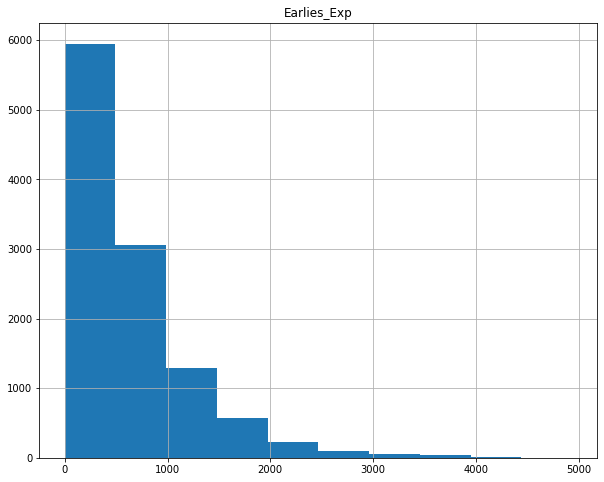

In [23]:
df.hist("Earlies_Exp", figsize=(10,8))

<AxesSubplot:>

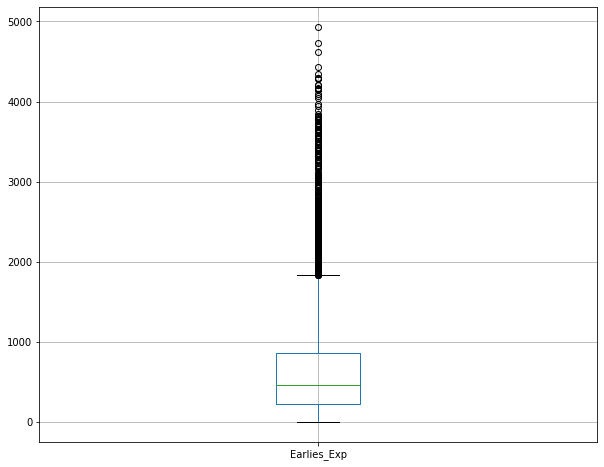

In [24]:
df.boxplot("Earlies_Exp", figsize=(10,8))

array([[<AxesSubplot:title={'center':'Earlies_Rec'}>]], dtype=object)

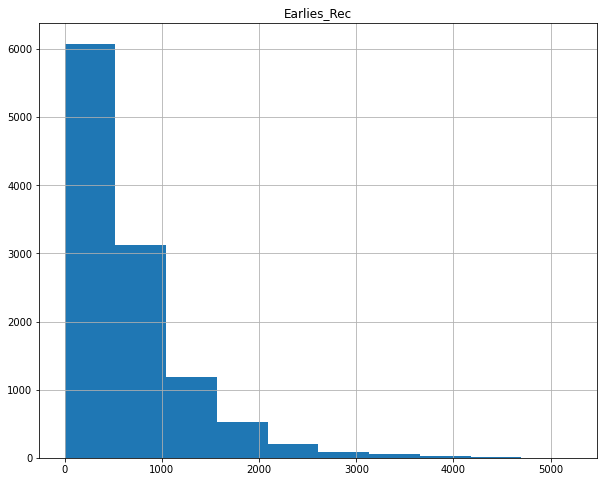

In [25]:
df.hist("Earlies_Rec", figsize=(10,8))

<AxesSubplot:>

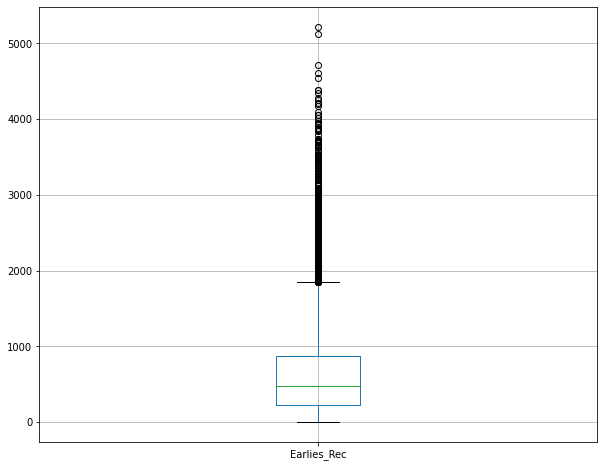

In [26]:
df.boxplot("Earlies_Rec", figsize=(10,8))

array([[<AxesSubplot:title={'center':'Rollover'}>]], dtype=object)

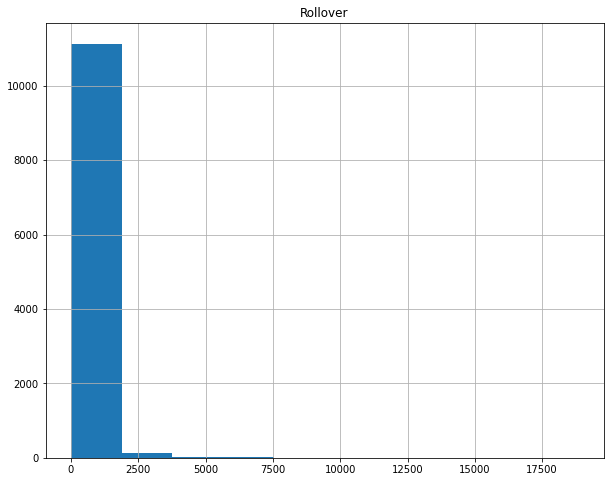

In [27]:
df.hist("Rollover", figsize=(10,8))

<AxesSubplot:>

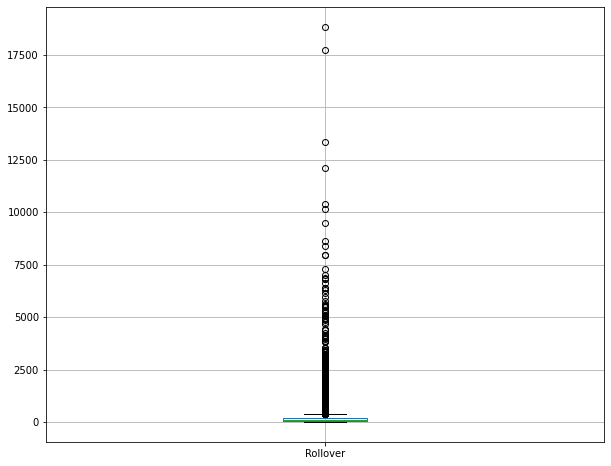

In [28]:
df.boxplot("Rollover", figsize=(10,8))

array([[<AxesSubplot:title={'center':'Sideline'}>]], dtype=object)

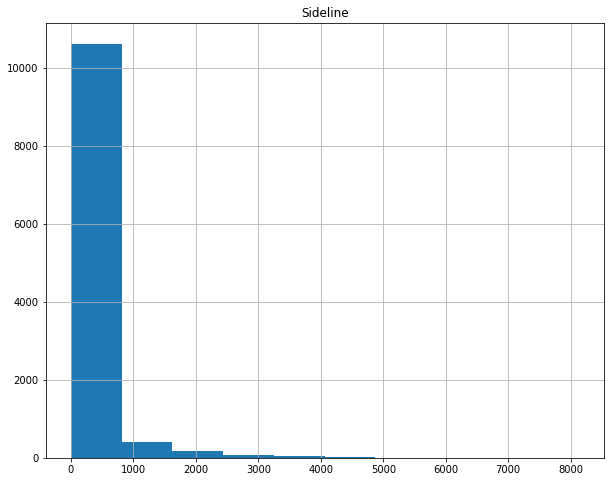

In [29]:
df.hist("Sideline", figsize=(10,8))

<AxesSubplot:>

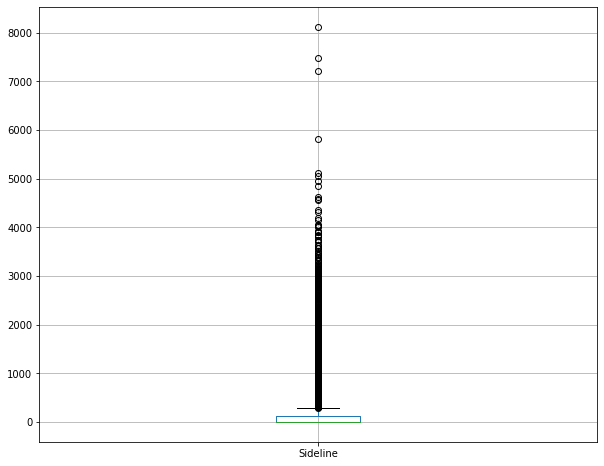

In [30]:
df.boxplot("Sideline", figsize=(10,8))

array([[<AxesSubplot:title={'center':'Returns'}>]], dtype=object)

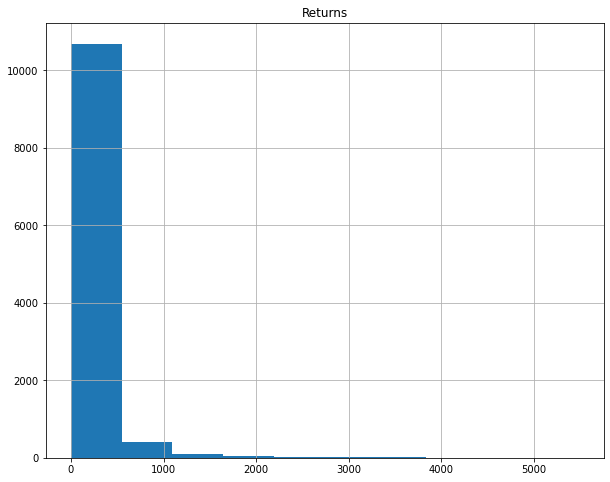

In [31]:
df.hist("Returns", figsize=(10,8))

<AxesSubplot:>

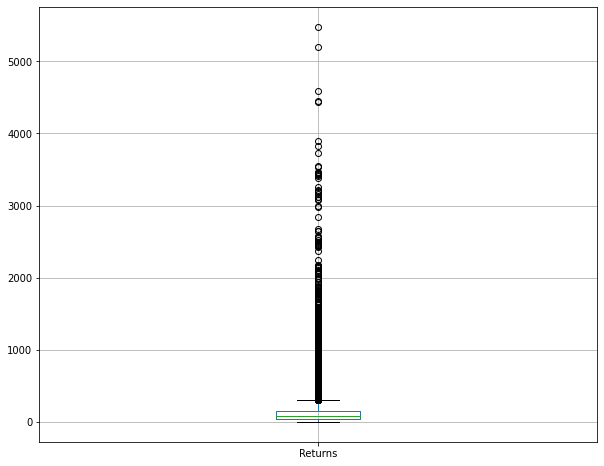

In [32]:
df.boxplot("Returns", figsize=(10,8))

array([[<AxesSubplot:title={'center':'R_Sideline'}>]], dtype=object)

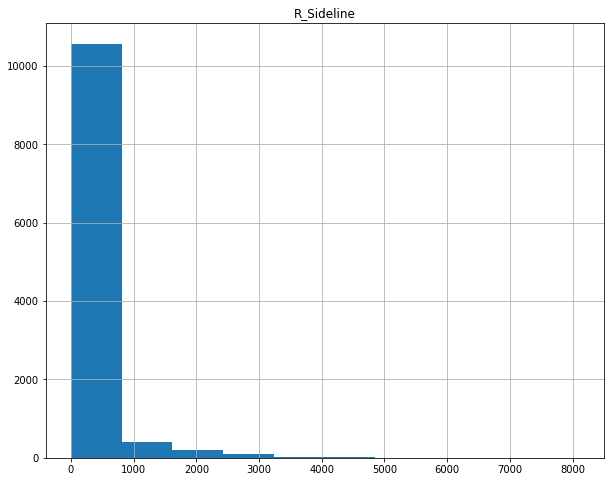

In [33]:
df.hist("R_Sideline", figsize=(10,8))

<AxesSubplot:>

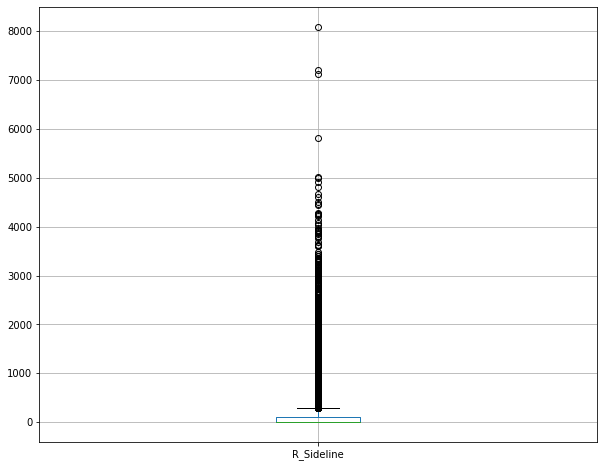

In [34]:
df.boxplot("R_Sideline", figsize=(10,8))

array([[<AxesSubplot:title={'center':'Rollover'}>]], dtype=object)

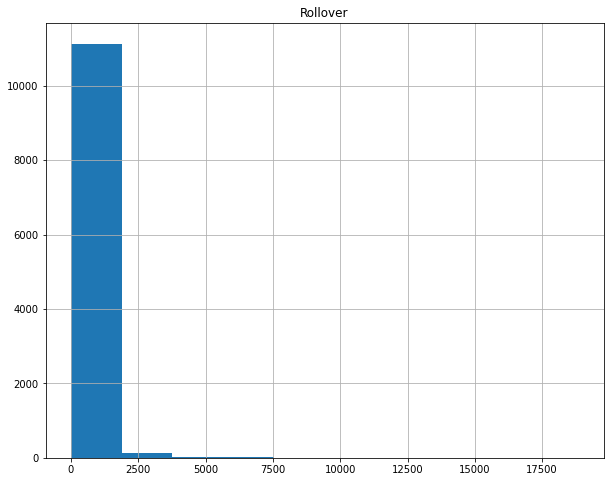

In [35]:
df.hist("Rollover", figsize=(10,8))

<AxesSubplot:>

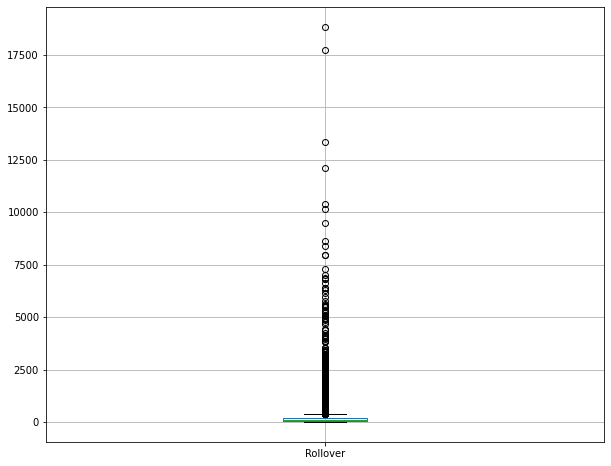

In [36]:
df.boxplot("Rollover", figsize=(10,8))

array([[<AxesSubplot:title={'center':'MNR_SNR_Exp'}>]], dtype=object)

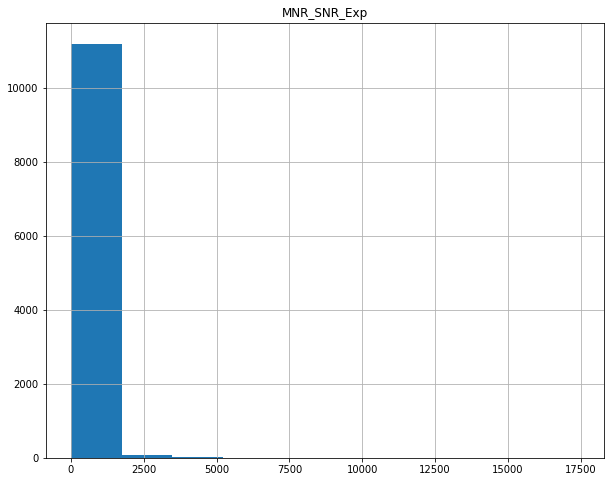

In [37]:
df.hist("MNR_SNR_Exp", figsize=(10,8))

<AxesSubplot:>

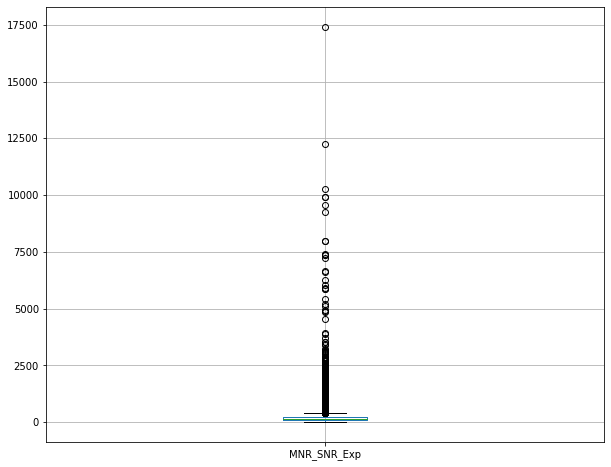

In [38]:
df.boxplot("MNR_SNR_Exp", figsize=(10,8))

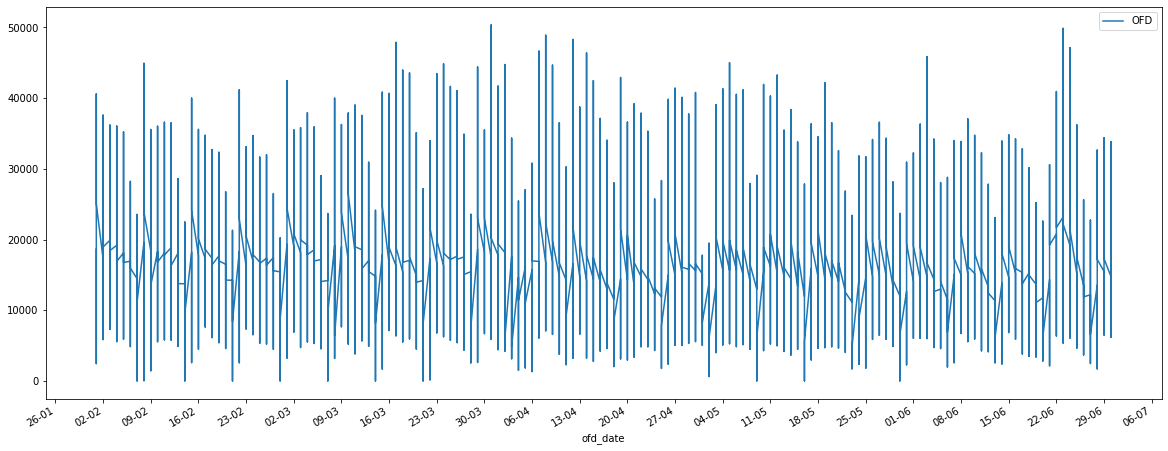

In [39]:
ax = df.plot(x = "ofd_date", y="OFD", figsize=(20,8))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))

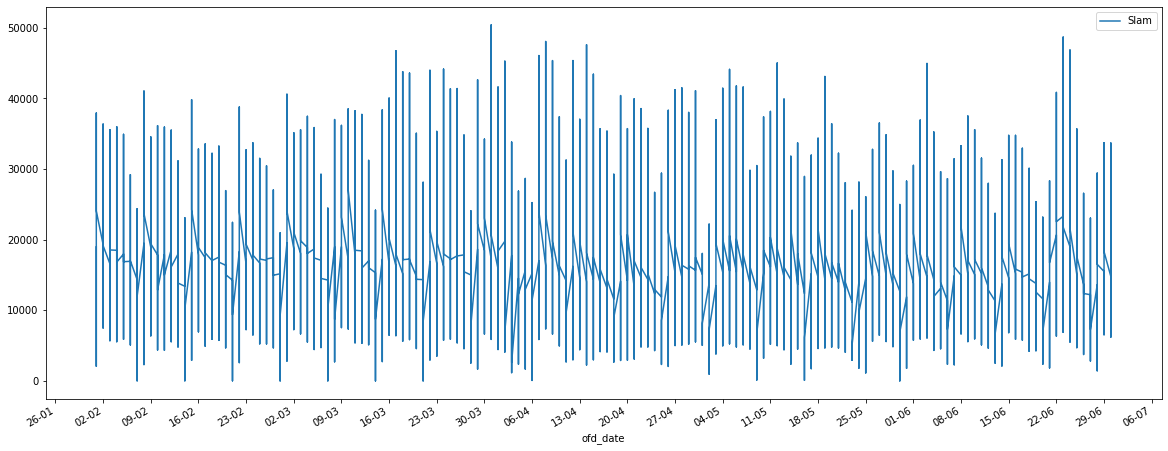

In [40]:
ax = df.plot(x = "ofd_date", y=["Slam"], figsize=(20,8))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))

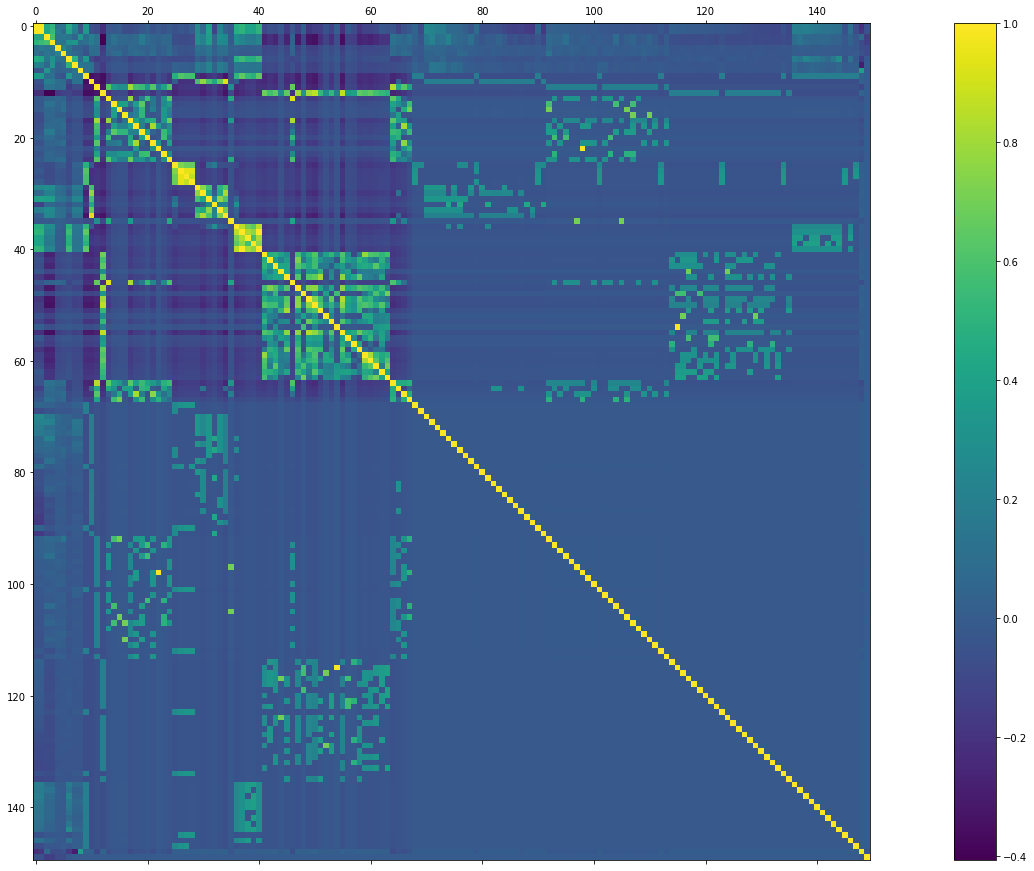

In [41]:
plt.matshow(df.corr(method = "pearson"))
cb = plt.colorbar()
plt.gcf().set_size_inches(30, 15)

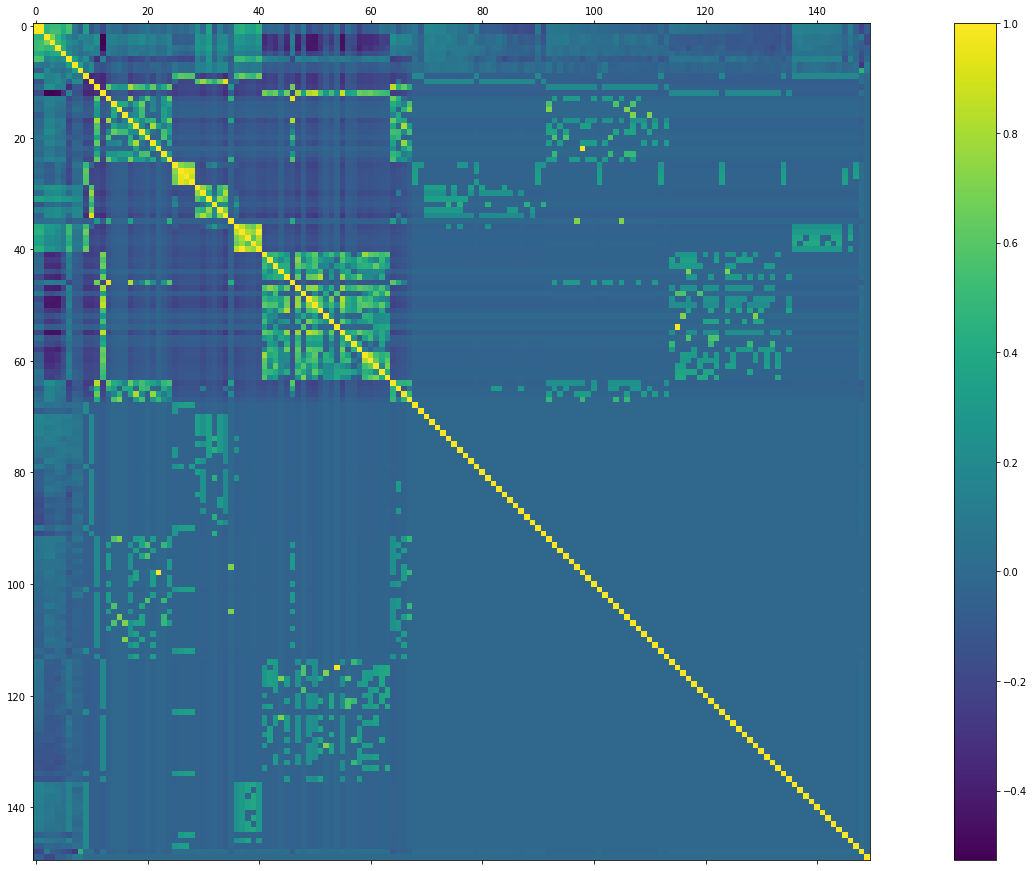

In [42]:
plt.matshow(df.corr(method = "spearman"))
cb = plt.colorbar()
plt.gcf().set_size_inches(30, 15)

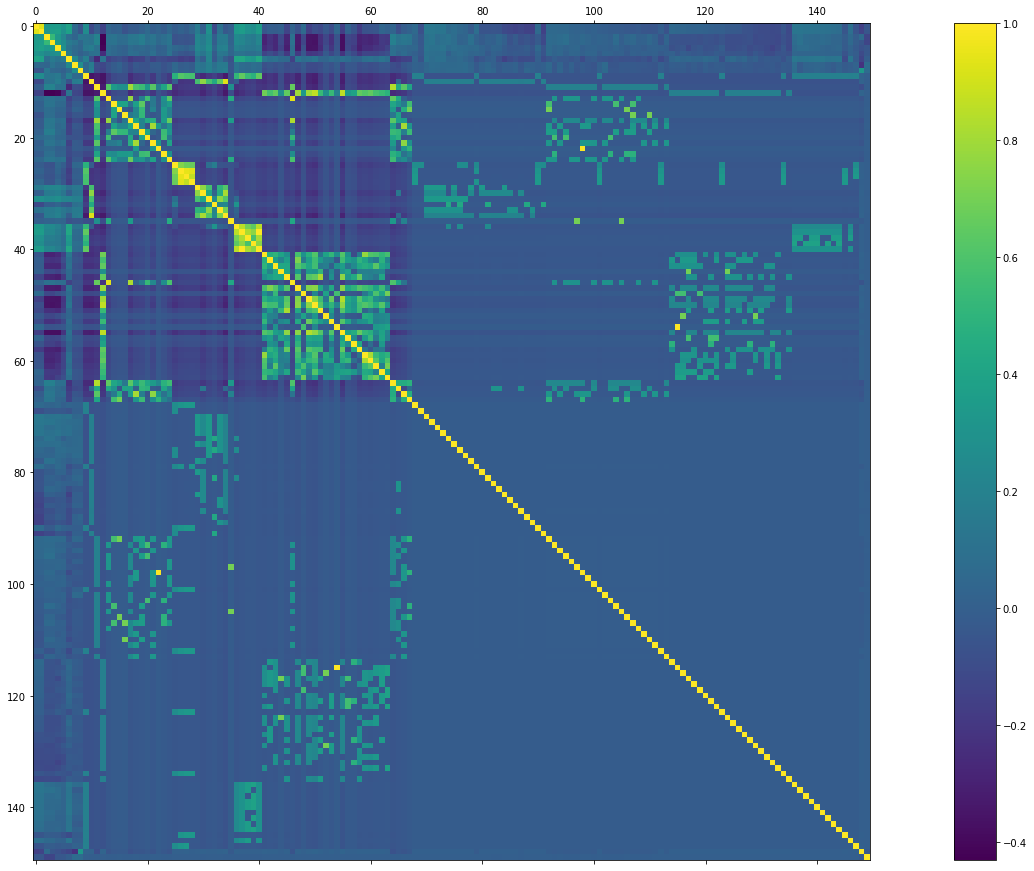

In [43]:
plt.matshow(df.corr(method = "kendall"))
cb = plt.colorbar()
plt.gcf().set_size_inches(30, 15)

In [44]:
df.corr(method = "pearson").to_excel("..\Data\Preprocessed\correlation_matrix.xlsx")

We can see a lot of outliers in multiple categories which could be negatively impacting our correlation and thus our final model output. Hence, we should attempt to remove outliers to avoid underfitting. However, if we remove too many outliers, we would have NO warning whatsoever from the model for extreme cases, so potentially creating another model with the outliers included would be a good idea, so that workers could decide which model to weigh more depending on the circumstances.

## Examining seasonality of outliers

Some of the outliers may be due to logistical issues, while others may be due to seasonal trends which SHOULD be accounting for in any decent model. hence, we should plot the suspected data against the day to check for any seasonality

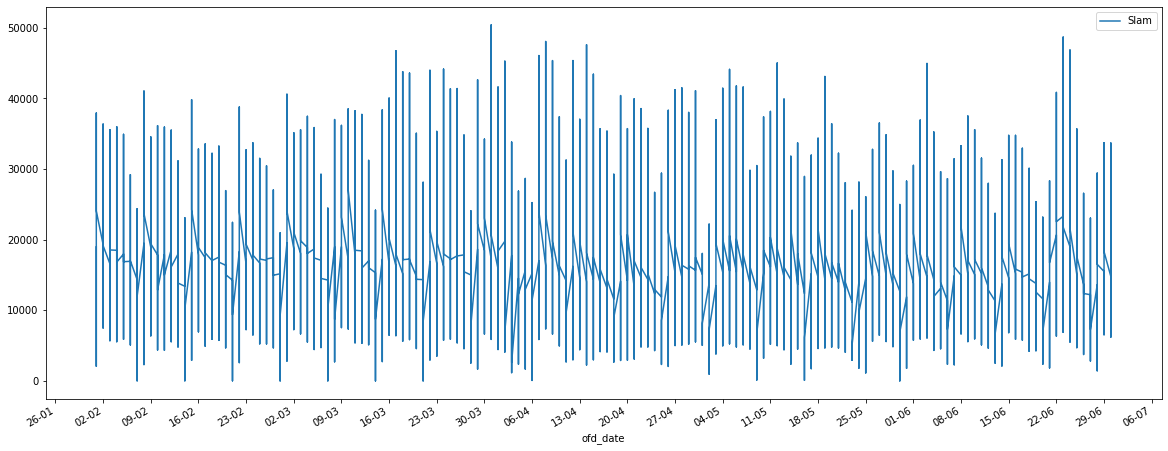

In [83]:
ax = df.plot(y = "Slam", x = "ofd_date", figsize = (20,8))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))

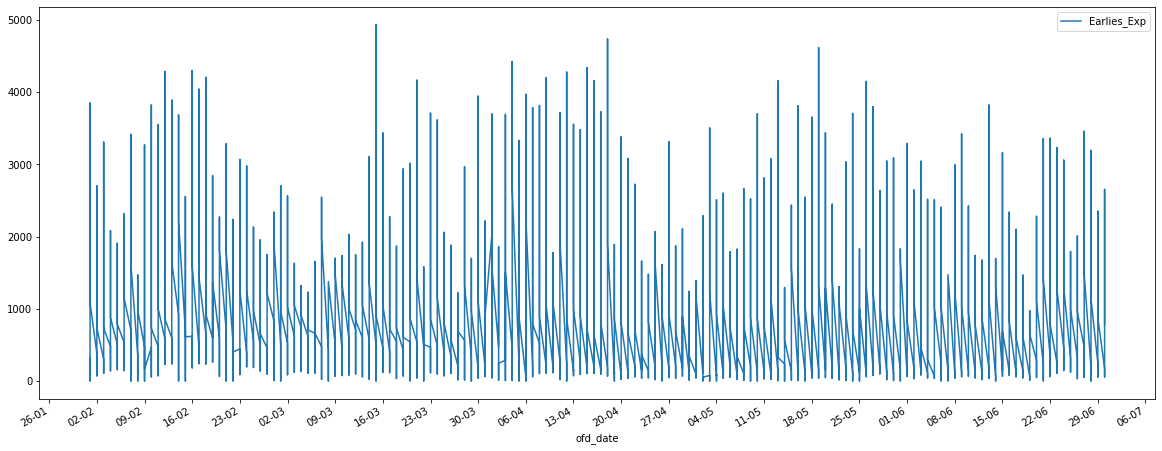

In [84]:
ax = df.plot(y = "Earlies_Exp", x = "ofd_date", figsize = (20,8))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))

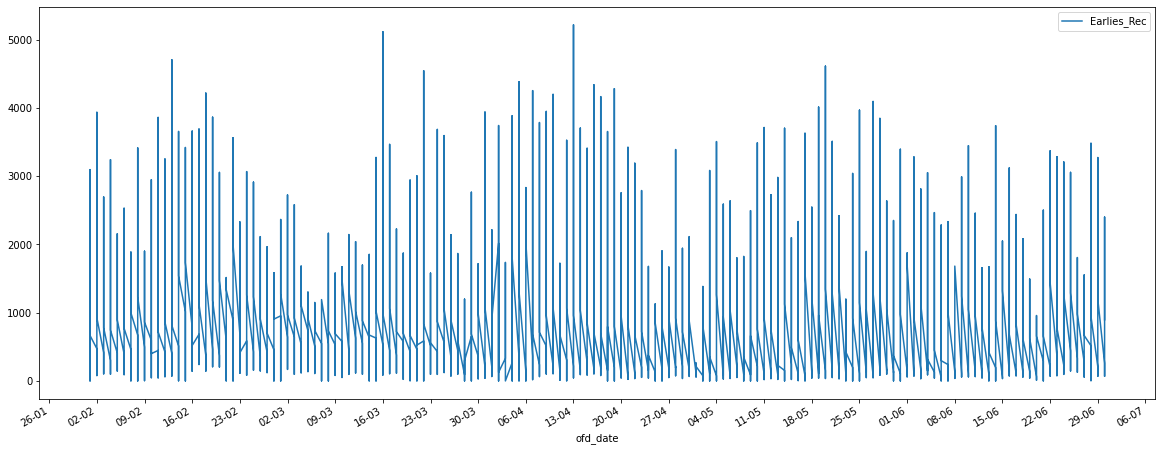

In [85]:
ax = df.plot(y = "Earlies_Rec", x = "ofd_date", figsize = (20,8))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))

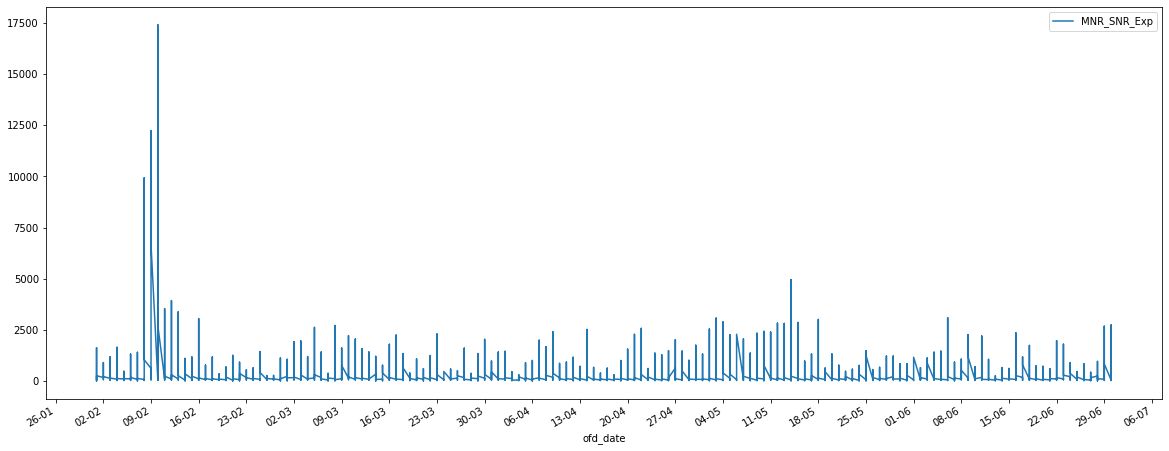

In [86]:
ax = df.plot(y = "MNR_SNR_Exp", x = "ofd_date", figsize = (20,8))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))

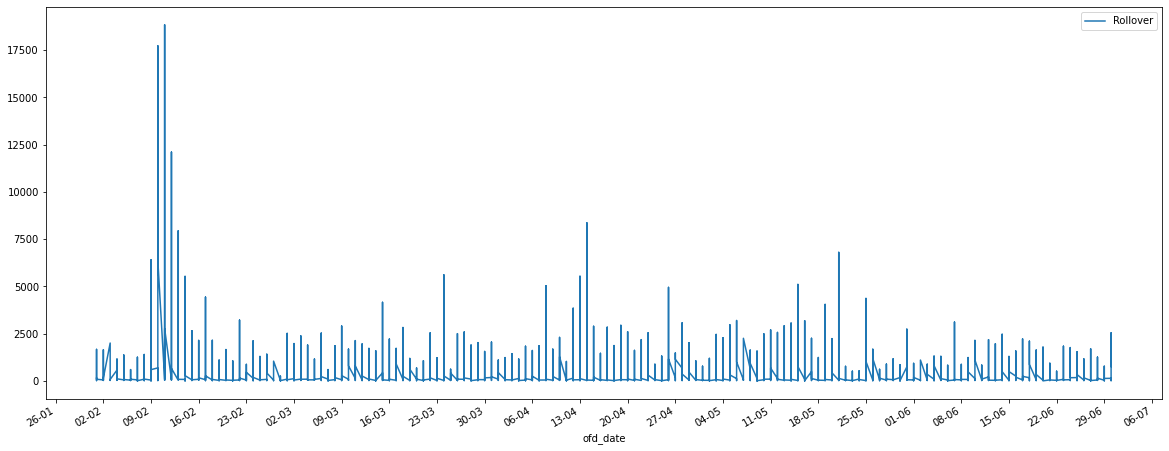

In [87]:
ax = df.plot(y = "Rollover", x = "ofd_date", figsize = (20,8))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))

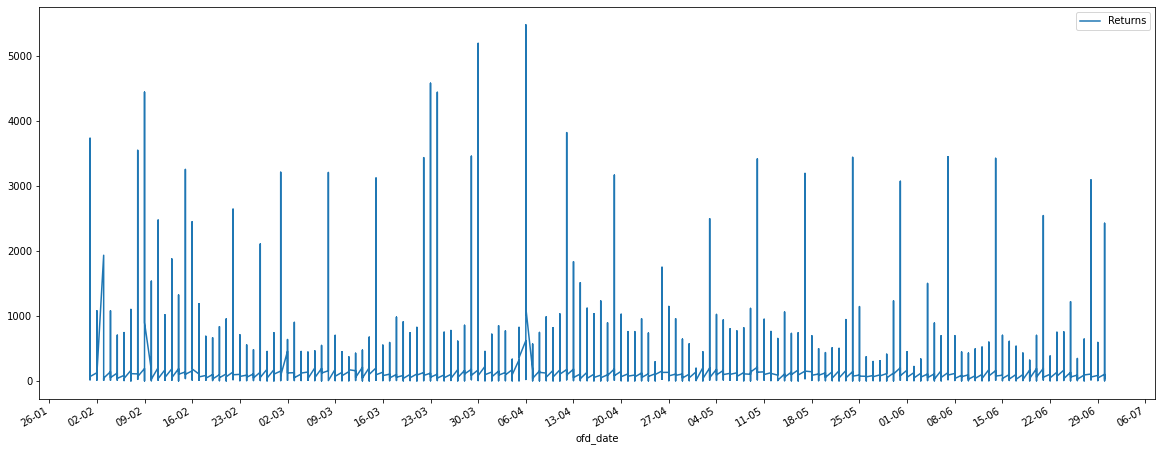

In [88]:
ax = df.plot(y = "Returns", x = "ofd_date", figsize = (20,8))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))

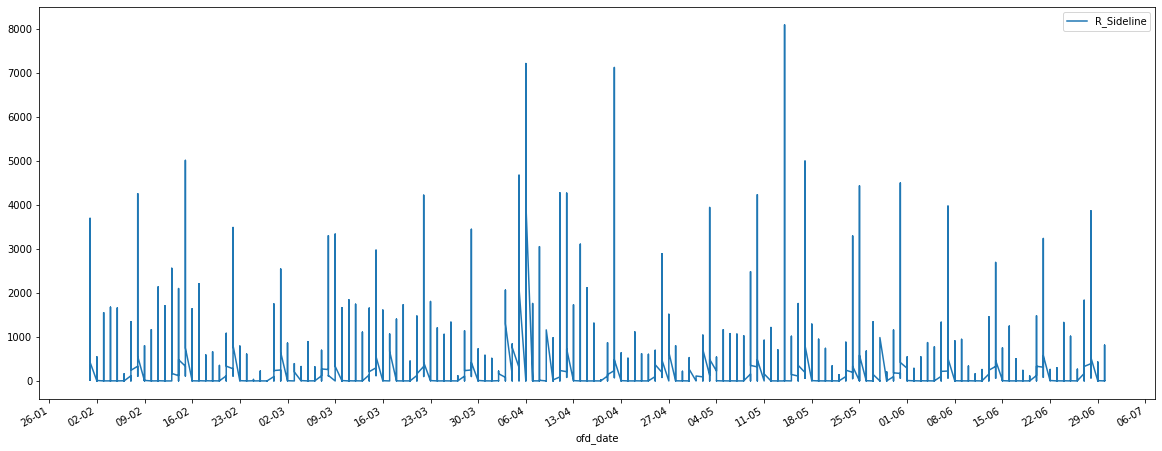

In [90]:
ax = df.plot(y = "R_Sideline", x = "ofd_date", figsize = (20,8))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))

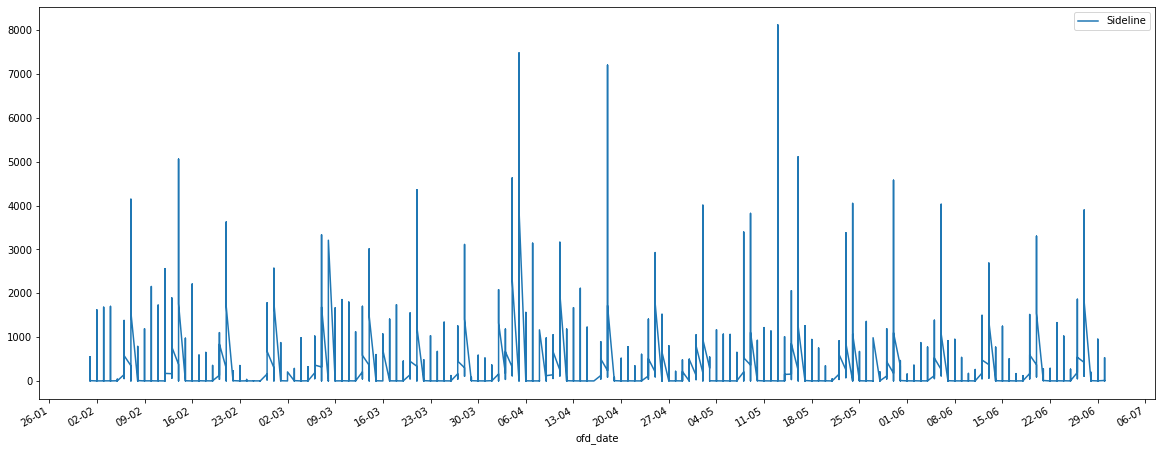

In [91]:
ax = df.plot(y = "Sideline", x = "ofd_date", figsize = (20,8))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))

## Result

We can see that the outliers represent some seasonal trends, hence we can't simply throw them all out, instead we have to try and correlate them with a combination of the day of the week and the week number in our final model. We would also like to find out if the outliers are occuring in specific countries or fulfillment centres or delivery centres by taking them out into a separate dataframe and analyzing them.

<AxesSubplot:xlabel='weekday', ylabel='Earlies_Exp'>

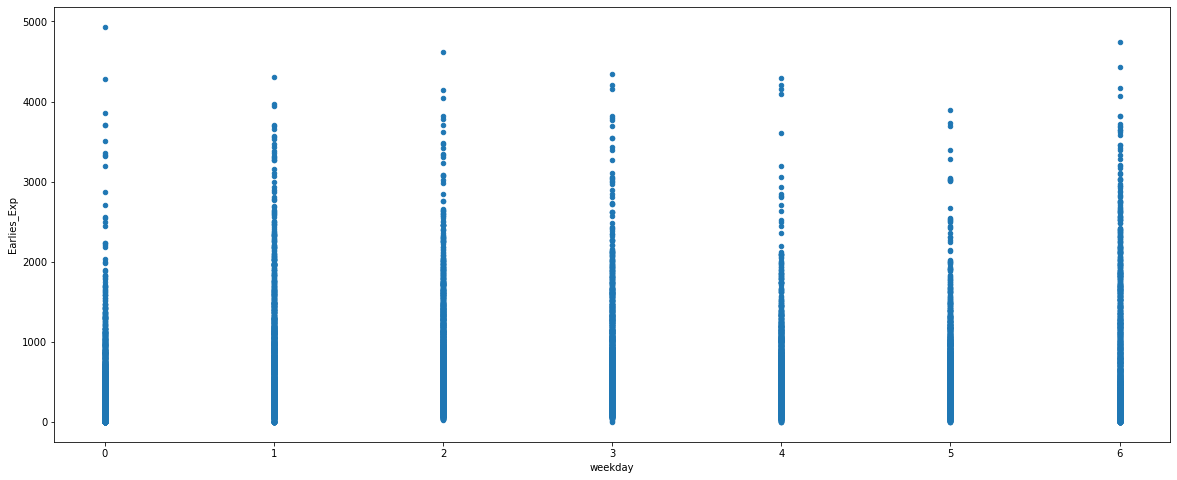

In [52]:
df.plot(y = "Earlies_Exp", x = "weekday", figsize = (20,8), kind="scatter")

<AxesSubplot:xlabel='weekday', ylabel='Earlies_Rec'>

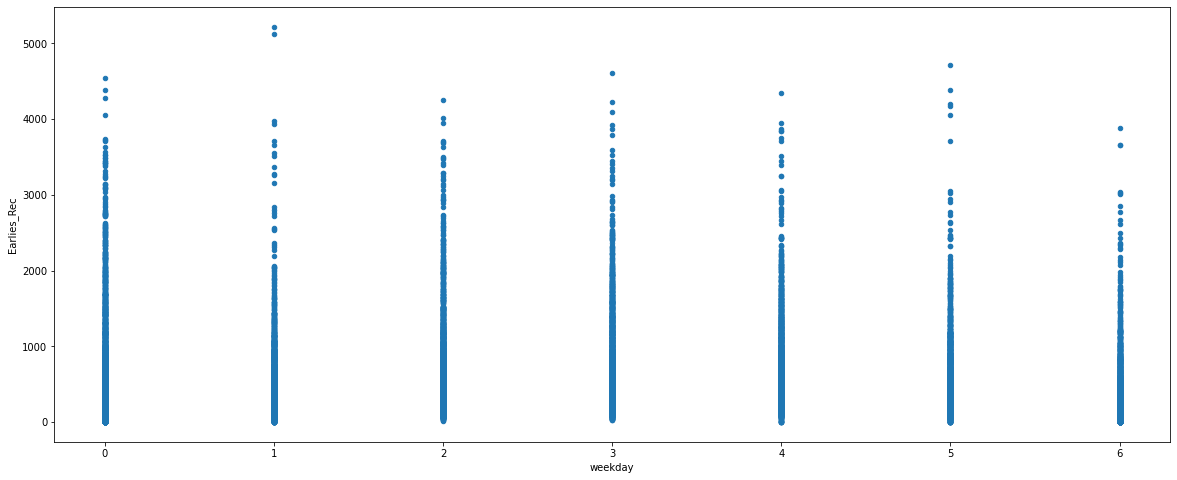

In [53]:
df.plot(y = "Earlies_Rec", x = "weekday", figsize = (20,8), kind="scatter")

<AxesSubplot:xlabel='weekday', ylabel='MNR_SNR_Exp'>

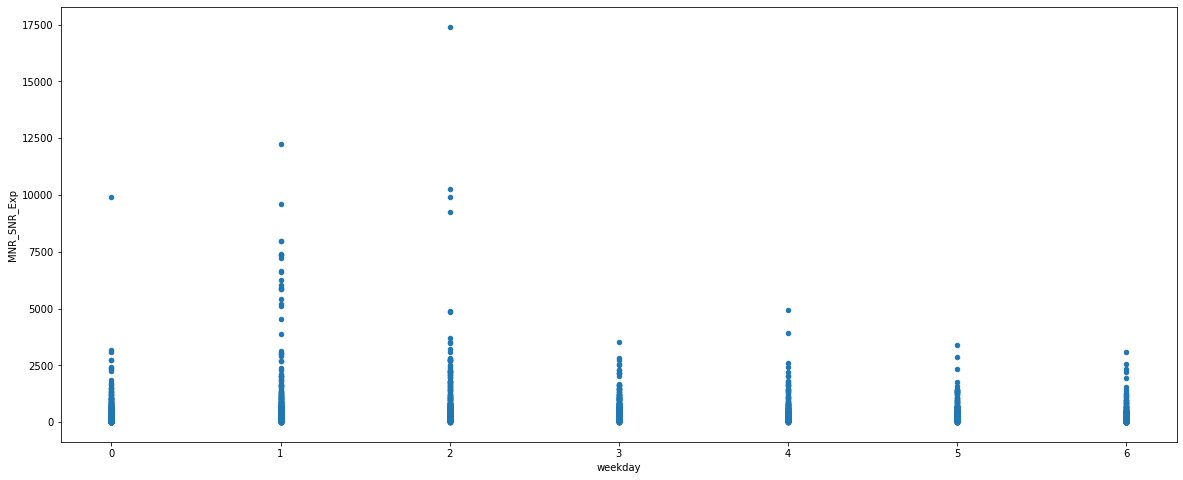

In [54]:
df.plot(y = "MNR_SNR_Exp", x = "weekday", figsize = (20,8), kind="scatter")

<AxesSubplot:xlabel='weekday', ylabel='Rollover'>

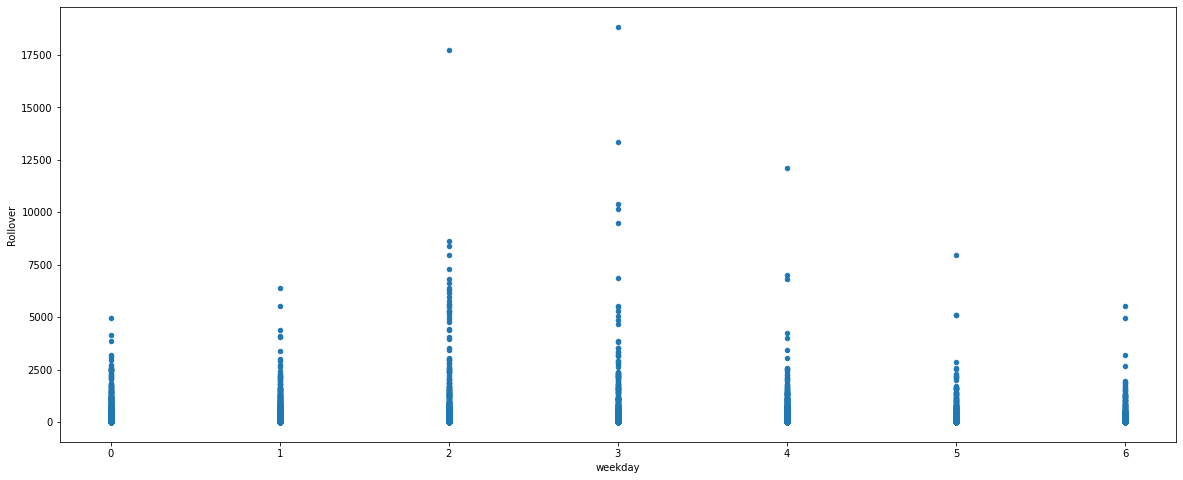

In [55]:
df.plot(y = "Rollover", x = "weekday", figsize = (20,8), kind="scatter")

<AxesSubplot:xlabel='weekday', ylabel='Returns'>

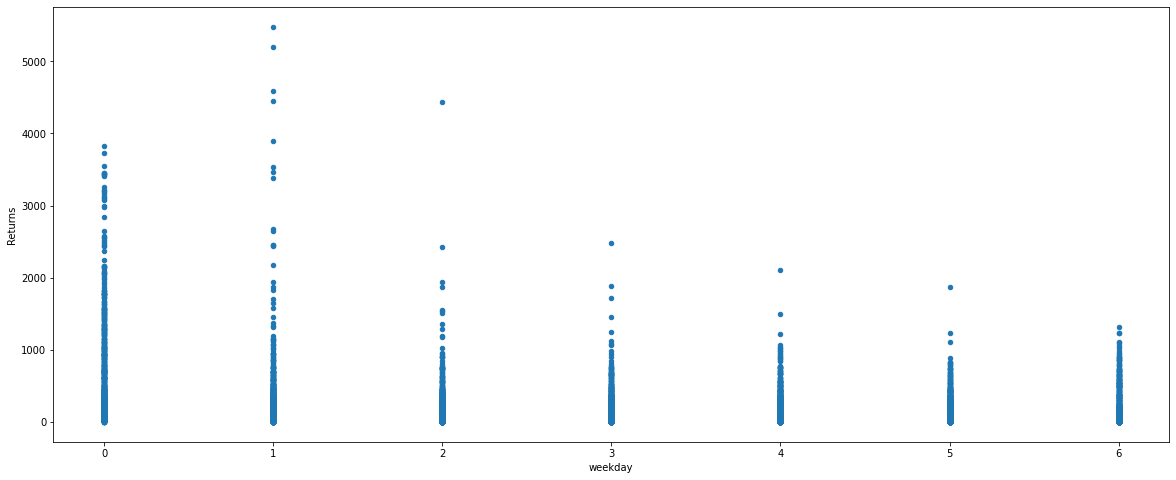

In [56]:
df.plot(y = "Returns", x = "weekday", figsize = (20,8), kind="scatter")

<AxesSubplot:xlabel='weekday', ylabel='R_Sideline'>

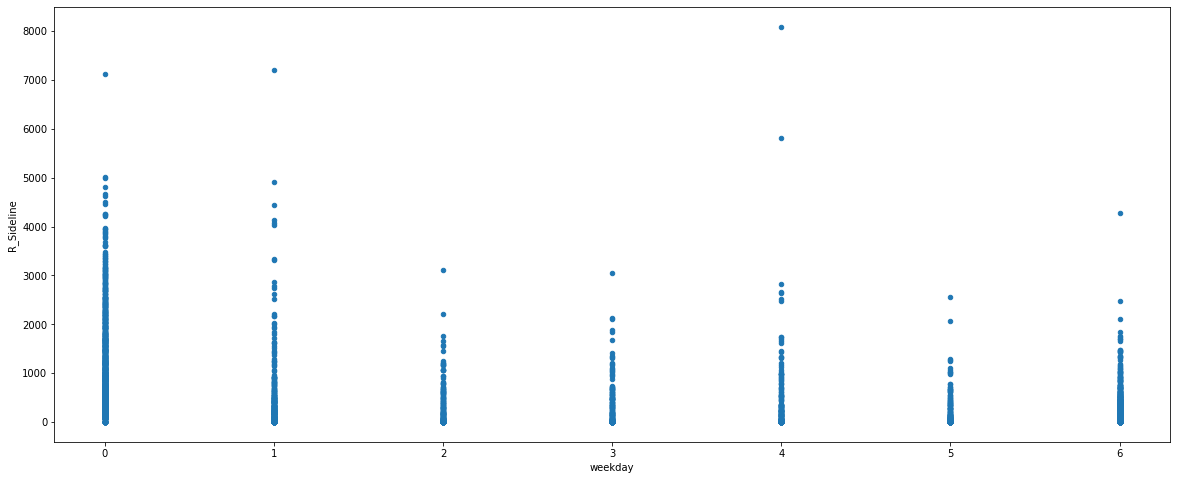

In [57]:
df.plot(y = "R_Sideline", x = "weekday", figsize = (20,8), kind="scatter")

<AxesSubplot:xlabel='weekday', ylabel='Sideline'>

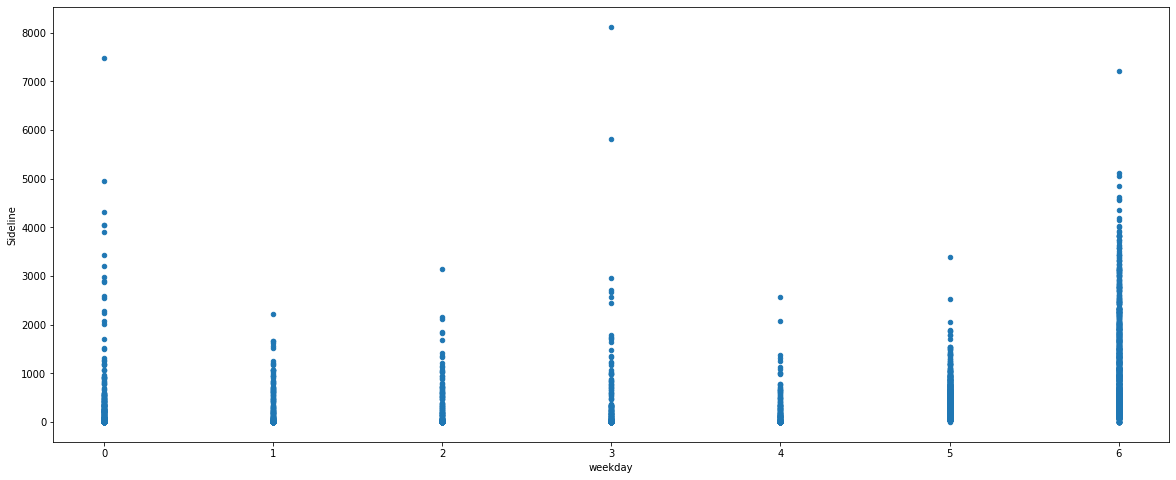

In [58]:
df.plot(y = "Sideline", x = "weekday", figsize = (20,8), kind="scatter")

In [59]:
for col in df.columns:
    print(col)

ofd_date
OFD
Slam
Earlies_Exp
Earlies_Rec
MNR_SNR_Exp
Rollover
Returns
R_Sideline
Sideline
Country_A
Country_B
Country_C
Country_D
Fulfil_F1
Fulfil_F10
Fulfil_F11
Fulfil_F12
Fulfil_F13
Fulfil_F14
Fulfil_F15
Fulfil_F16
Fulfil_F17
Fulfil_F18
Fulfil_F19
Fulfil_F2
Fulfil_F20
Fulfil_F21
Fulfil_F22
Fulfil_F23
Fulfil_F24
Fulfil_F25
Fulfil_F26
Fulfil_F27
Fulfil_F28
Fulfil_F29
Fulfil_F3
Fulfil_F30
Fulfil_F31
Fulfil_F32
Fulfil_F33
Fulfil_F34
Fulfil_F35
Fulfil_F36
Fulfil_F37
Fulfil_F38
Fulfil_F39
Fulfil_F4
Fulfil_F40
Fulfil_F41
Fulfil_F42
Fulfil_F43
Fulfil_F44
Fulfil_F45
Fulfil_F46
Fulfil_F47
Fulfil_F48
Fulfil_F49
Fulfil_F50
Fulfil_F51
Fulfil_F52
Fulfil_F53
Fulfil_F54
Fulfil_F55
Fulfil_F56
Fulfil_F6
Fulfil_F7
Fulfil_F8
Fulfil_F9
Delivery_D1
Delivery_D10
Delivery_D11
Delivery_D12
Delivery_D13
Delivery_D14
Delivery_D15
Delivery_D16
Delivery_D17
Delivery_D18
Delivery_D19
Delivery_D2
Delivery_D20
Delivery_D21
Delivery_D22
Delivery_D23
Delivery_D24
Delivery_D25
Delivery_D26
Delivery_D27
Delivery_D28
D

In [60]:
cols = df.columns[1:10]
df1 = df[cols]
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3-Q1
print(IQR)

OFD            7815.0
Slam           7783.0
Earlies_Exp     647.0
Earlies_Rec     651.0
MNR_SNR_Exp     132.0
Rollover        132.0
Returns         108.0
R_Sideline      115.0
Sideline        119.0
dtype: float64


In [92]:
(df1 < (Q1 - (1.5 * IQR))) | (df1 > (Q3 + (1.5 * IQR)))

,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline
11308,False,False,False,False,False,False,False,True,False
11307,False,False,False,False,False,False,False,False,False
11306,False,False,False,False,False,False,False,False,False
11305,False,False,False,False,False,False,False,False,False
11304,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
4,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False


In [93]:
outlier_indices = df1[~((df1 < (Q1 - 1.5 * IQR)) | (df1 > (Q3 + 1.5 * IQR))).any(axis=1)].index
df_outliers = df.iloc[outlier_indices]
df_outliers

,ofd_date,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline,...,Delivery_D75,Delivery_D76,Delivery_D77,Delivery_D78,Delivery_D79,Delivery_D8,Delivery_D80,Delivery_D9,weekday,week_no
1,2021-06-30,12736.0,13111.0,655.0,823.0,211.0,29.0,17.0,2.0,1.0,...,0,0,0,0,0,0,0,0,2.0,26.0
2,2021-06-30,14562.0,15651.0,1028.0,1910.0,225.0,35.0,47.0,3.0,1.0,...,0,0,0,0,0,0,0,0,2.0,26.0
3,2021-06-30,11165.0,11467.0,514.0,769.0,56.0,39.0,29.0,0.0,1.0,...,0,0,0,0,0,0,0,0,2.0,26.0
4,2021-06-30,10006.0,10423.0,399.0,842.0,52.0,60.0,65.0,1.0,1.0,...,0,0,0,0,0,0,0,0,2.0,26.0
5,2021-06-30,15707.0,16025.0,637.0,924.0,90.0,722.0,52.0,2.0,3.0,...,0,0,0,0,0,0,0,0,2.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11301,2021-02-01,18944.0,18594.0,465.0,447.0,86.0,103.0,172.0,227.0,2.0,...,0,0,0,0,0,0,0,0,0.0,5.0
11302,2021-02-01,19084.0,18841.0,272.0,371.0,89.0,125.0,124.0,218.0,2.0,...,0,0,0,0,0,0,0,0,0.0,5.0
11304,2021-02-01,16025.0,15768.0,487.0,383.0,62.0,69.0,195.0,15.0,1.0,...,0,0,0,0,0,0,0,0,0.0,5.0
11305,2021-02-01,18986.0,18861.0,318.0,446.0,83.0,100.0,107.0,248.0,1.0,...,0,0,0,0,0,0,0,0,0.0,5.0


More than half of our data consists of outliers if we consider this Quantile metric for removing data. This is not acceptable, since a lot of seasonal trends and extreme points unrelated to operational issues would get deleted. We need a different method of removing outliers while maintaining seasonality.